In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
data_path = "data/"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                           transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2616)
                              )
                           ]))

cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                           transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2616)
                              )
                           ]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size=3) # Вместо сокращенной формы записи kernel_size=3 мы можем передать кортеж, показанный в выведенных результатах: kernel_size=(3, 3)

In [ ]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

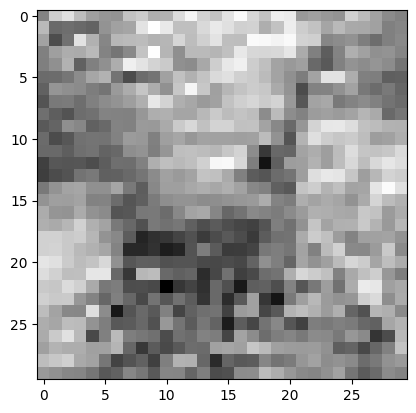

In [ ]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

# 8.2.1. Дополнение нулями по краям

Применение
сверточного ядра в виде взвешенной суммы пикселей в окрестности размера
3 × 3 требует наличия соседних пикселей во всех направлениях. А в точке i00
соседние пиксели есть только справа и снизу. По умолчанию сверточное ядро
в PyTorch проходит по входному изображению, получая ширина - ширина_ядра + 1
по горизонтали и вертикали. В случае ядер нечетного размера в результате получаются изображения, которые меньше с каждой стороны на половину ширины
сверточного ядра (в нашем случае 3 // 2 = 1). Поэтому нам и не хватает по два
пикселя в каждом измерении.
Впрочем, PyTorch позволяет дополнять нулями (padding) изображения, путем
добавления границ с помощью фиктивных (ghost) пикселей с нулевымзначением.

В нашем случае параметр padding=1 при kernel_size=3 означает появление
у i00 набора дополнительных соседей сверху и слева, что позволяет вычислять
выходной сигнал свертки даже в углу исходного изображения1
. В итоге размер
выходного изображения оказывается точно таким же, как и входного:

In [ ]:
conv = nn.Conv2d(3, 1, padding=1, kernel_size=3)
output = conv(img.unsqueeze(0))
output.shape

torch.Size([1, 1, 32, 32])

Для ядер четного размера пришлось бы дополнять другим количеством соседей
слева и справа (а также сверху и снизу). PyTorch не предоставляет подобной возможности в самой свертке, но дает возможность решить эту задачу с помощью функции
torch.nn.functional.pad. Но лучше придерживаться нечетных размеров ядер; ядра четного
размера встречаются редко.

# 8.2.2. Обнаружение признаков с помощью сверток

Мы уже говорили, что weight и bias — это параметры, усваиваемые посредством
обратного распространения ошибки, точно так же, как weight и bias в nn.Linear.
Однако можно поэкспериментировать со сверткой, задавая весовые коэффициенты вручную, и посмотреть, что получится.
Сначала обнулим bias, просто чтобы исключить все мешающие факторы, после
чего зададимконстантное значение weight, чтобы каждый пиксель выходного изображения получал среднее значение своих соседей. Для каждой окрестности 3 × 3:

In [ ]:
with torch.no_grad():
     conv.bias.zero_()

with torch.no_grad():
     conv.weight.fill_(1.0 / 9.0)

Можно было воспользоваться conv.weight.one_() — при этом каждый пиксель
выходного изображения был бы равен сумме окрестных пикселей. Различия незначительны, разве что значения пикселей в выходном изображении оказались
бы в девять раз больше

В любом случае взглянем, как это повлияет на наше изображение

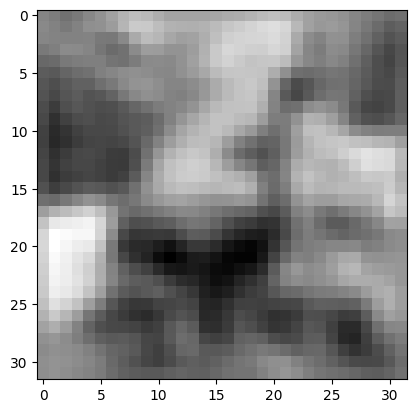

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
     conv.weight[:] = torch.tensor([[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]])
     conv.bias.zero_()

# От большого к малому: понижающая дискретизация

1. Усреднять значения четырех входных пикселей — изначально весьма распространенный подход под названием «усредняющая субд
искретизация» (average pooling), несколько утративший популярность в последнее время;

2. Брать максимум из значений четырех входных пикселей — в настоящее время чаще всего используется именно этот подход: субдискретизация с выбором максимального значения (max pooling). Его недостаток в том, что отбрасываются три четверти данных;

3. Шаговая свертка (strided convolution), при которой учитывается лишь каждый N-й пиксель — свертка 3 × 4 с шагом 2 позволяет учесть значения всех пикселей предыдущего слоя. Судя по публикациям, этот подход весьмаперспективен, хотя и не вытеснил пока что субдискретизацию с выбором максимального значения

![image.png](attachment:image.png)

Возможности субдискретизации с выбором максимального значения предоставляет модуль nn.MaxPool2d (как и для свертки, существуют его версии для одномерных и трехмерных данных). В качестве входного аргумента ему передается
размер окрестности для работы операции субдискретизации. Например, для
понижающей дискретизации изображения в два раза необходимо передавать
значение 2. Давайте проверим, что все работает правильно, прямо на нашем
входном изображении:

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

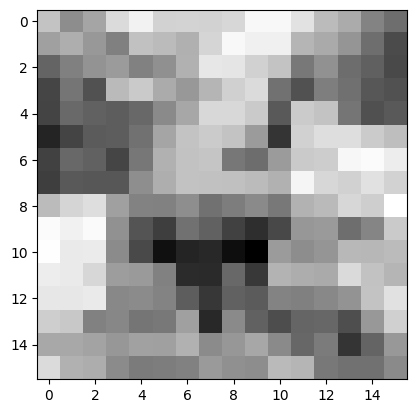

In [ ]:
plt.imshow(output[0, 0], cmap='gray');

In [ ]:
output.shape

torch.Size([1, 3, 16, 16])

# Сочетание сверточных слоев и понижающей дискретизации для лучшего распознавания

In [ ]:
# model = nn.Sequential(
#     nn.Conv2d(3, 16, padding=1, kernel_sise=3),
#     nn.Tanh(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(16, 8, padding=1, kernel_size=3),
#     nn.Tanh(),
#     nn.MaxPool2d(2),
#     ...,
#     nn.Linear(8*8*8, 32),
#     nn.Tanh(),
#     nn.Linear(32, 2)
# )

# 8.3.1. Наша сеть как подкласс nn.Module

Напишем нашу сеть в виде подмодуля. Для этого создадим все экземпляры
всех слоев nn.Conv2d, nn.Linear и т. д., которые выше передавали в конструктор,
а затем воспользуемся этими экземплярами один за другим в функции forward:

In [ ]:
class Net(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
          self.act1 = nn.Tanh()
          self.pool1 = nn.MaxPool2d(2)
          self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
          self.act2 = nn.Tanh()
          self.pool2 = nn.MaxPool2d(2)
          self.fc1 = nn.Linear(8 * 8 * 8, 32)
          self.act3 = nn.Tanh()
          self.fc2 = nn.Linear(32, 2)

      def forward(self, x):
          out = self.pool1(self.act1(self.conv1(x)))
          out = self.pool2(self.act2(self.conv2(out)))
          out = out.view(-1, 8 * 8 * 8) # Шаг изменения формы, который отсутствовал у нас ранее
          out = self.act3(self.fc1(out))
          out = self.fc2(out)
          return out

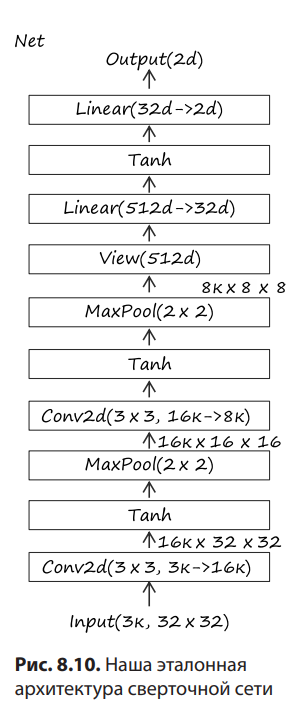

# 8.3.2. Как PyTorch отслеживает параметры и подмодули

Можно вызывать любые методы подкласса nn.Module. Например, в модели,
где процесс обучения существенно отличается от, скажем, предсказания, не
помешает метод predict. Учтите, что вызовы подобных методов аналогичны
вызову forward вместо самого модуля: они ничего не знают о точках привязки,
и JIT при их использовании не видит структуры модуля, поскольку отсутствует
эквивалент элементов __call__, показанных в подразделе 6.2.1.
Благодаря этому для доступа из Net к параметрам подмодулей не требуется
каких-либо дополнительных действий пользователя:

In [ ]:
model = Net()

In [ ]:
numel_list = [p.numel() for p in model.parameters()]

In [ ]:
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
          self.fc1 = nn.Linear(8 * 8 * 8, 32)
          self.fc2 = nn.Linear(32, 2)

      def forward(self, x):
          out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
          out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
          out = out.view(-1, 8 * 8 * 8)
          out = torch.tanh(self.fc1(out))
          out = self.fc2(out)
          return out

Намного лаконичнее и полностью эквивалентно предыдущему описанию класса Net из подраздела 8.3.1. Обратите внимание, что по-прежнему имеет смысл
создать экземпляры модулей, требующих несколько параметров для их инициализации в конструкторе.

Давайте еще раз проверим, что наша модель работает, а затем перейдем к циклу
обучения:

In [ ]:
model = Net()
#output = model(img.unsqueeze(0))

In [ ]:
print([p.numel() for p in model.parameters()])

[1200, 16, 3200, 8, 16384, 32, 64, 2]


In [ ]:
|output

# 8.4. Обучаем нашу сверточную сеть

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs =  model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train+=loss.item()

        if epoch == 1 or epoch % 10 == 0:
           print('{} Epoch {}, Training loss {}'. format(
                 datetime.datetime.now(), epoch,
                 loss_train / len(train_loader)))

In [ ]:
# train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
# model = Net()
# optimizer = optim.SGD(model.parameters(), lr=1e-2)
# loss_fn = nn.CrossEntropyLoss()

# training_loop(
#     n_epochs = 100,
#     optimizer = optimizer,
#     model = model,
#     loss_fn = loss_fn,
#     train_loader = train_loader
# )

# 8.4.1. Измерение степени безошибочности

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [ ]:
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

            print("Accuracy {}: {:.2f}".format(name, correct / total))
# validate(model, train_loader, val_loader)

# 8.4.2. Сохранение и загрузка модели
Поскольку мы пока что удовлетворены результатами работы модели, не помешает ее сохранить, правда? Сделать это очень просто. Давайте сохраним
модель в файл:

In [ ]:
# torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

Файл birds_vs_airplanes.pt теперь содержит все параметры объекта model:
весовые коэффициенты и смещения для двух модулей свертки и двух линейных
модулей. Да, никакой структуры, только весовые коэффициенты. Это значит,
что при развертывании модели для нашего друга в реальных условиях нам понадобится описание класса model, а еще нужно будет создать экземпляр и затем
загрузить в него обратно параметры:

In [ ]:
# loaded_model = Net() # Нужно убедиться, что мы не меняем определение сети между сохранением и последующей загрузкой состояния модели
# loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

# 8.4.3. Обучение на GPU

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
           print('{} Epoch {}, Training Loss {}'.format(
              datetime.datetime.now(), epoch,
              loss_train / len(train_loader)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(),  lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

Небольшая сложность при загрузке весовых коэффициентов сети: PyTorch попытается загрузить веса на то же устройство, с которого они были сохранены,
то есть весовые коэффициенты с GPU будут восстановлены на GPU. Поскольку
неизвестно, нужно ли нам то же устройство, существует два варианта: перенести
сеть на CPU перед сохранением или вернуть ее обратно после восстановления.
Более лаконичным вариантом будет потребовать от PyTorch переопределить
информацию об устройстве при загрузке весовых коэффициентов. Сделать
это можно посредством передачи методу torch.load ключевого аргумента
map_location:

In [ ]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

# 8.5.1. Расширение объема памяти: ширина

Чтобы не нужно было жестко «зашивать» числа в описании модели, удобно
передавать параметр init и параметризовать ширину модели, не забывая также
добавить параметр в вызов view в функции forward:

In [ ]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x), 2))
        out = F.max_pool2d(torch.tanh(self.conv2(out), 2))
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth()

Количество каналов и признаков для каждого слоя непосредственно связано
с числом параметров модели: при прочих равных условиях они повышают
разрешающие возможности (capacity) модели. Можно посмотреть, как мы уже
делали ранее, сколько параметров у нашей модели теперь:

In [ ]:
sum(p.numel() for p in model.parameters())

Чем больше разрешающие возможности модели, тем с большей степенью изменчивости входных сигналов сможет справиться модель, но в то же время
тем выше вероятность переобучения, поскольку модель сможет воспользоваться дополнительными параметрами для запоминания несущественных
аспектов входных данных. Мы уже обсуждали способы борьбы с переобучением, лучший из которых — увеличение размера выборки, или, в отсутствие
новых данных, дополнение данных посредством искусственных изменений
уже существующих.

# 8.5.2. Улучшаем сходимость модели и ее способности к обобщению: регуляризация

В PyTorch можно довольно легко реализовать регуляризацию путем добавления
коэффициента в формулу функции потерь. После вычисления функции потерь,
какая бы она ни была, можно пройти в цикле по параметрам модели, суммируя
их квадраты (для L2) или abs (для L1), и произвести обратное распространение
ошибки:

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train+=loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))

Впрочем, в оптимизаторе SGD в PyTorch уже есть параметр weight_decay, соответствующий 2 * lambda, который напрямую осуществляет затухание весов
во время их обновления, как описывалось выше. Он полностью эквивалентен
прибавлению L2-нормы весовых коэффициентов к функции потерь без необходимости накопления в функции потерь и вовлечения автоматического
вычисления градиентов.

# Не слишком полагаемся на отдельные входные сигналы: дропаут

Фактически в результате этой процедуры на каждой итерации формируются
слегка отличающиеся модели с различными топологиями нейронов, уменьшая
шансы нейронов модели скоординироваться в процессе запоминания, что происходит при переобучении. Можно также считать, что дропаут вносит возмущения
в генерируемые моделью признаки, производя эффект, схожий с дополнением
данных, но на этот раз по всей сети.
В PyTorch можно реализовать дропаут в модели с помощью добавления модуля
nn.Dropoutмежду нелинейной функцией активации и линейным или сверточным
модулем последующего слоя. В качестве аргумента необходимо указать вероятность, с которой будут обнуляться входные сигналы. Для сверток необходимо
использовать специализированные слои nn.Dropout2d или nn.Dropout3d, обнуляющие целые каналы входных сигналов:

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.conv1 = nn.conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

В этом фрагменте текста обсуждается важный момент относительно использования модуля Dropout в PyTorch во время обучения и во время использования обученной модели в реальных условиях.

1. **Во время обучения:**
   - Во время обучения, когда модель подвергается обратному распространению ошибки и обновлению весов, Dropout применяется, и некоторые нейроны "выключаются" с вероятностью, указанной при создании слоя Dropout (например, `nn.Dropout(p=0.5)` означает 50% вероятность выключения).

2. **Во время использования обученной модели:**
   - Когда вы используете обученную модель для предсказания новых данных, вы обычно не хотите применять Dropout, так как это может привести к ненадежным и непредсказуемым результатам. В этот момент вероятность выключения должна быть равна нулю.
   - PyTorch предоставляет методы `model.train()` и `model.eval()`, которые переключают модель между режимами обучения и оценки. Когда вы вызываете `model.train()`, модель находится в режиме обучения, и Dropout применяется. Когда вы вызываете `model.eval()`, модель переключается в режим оценки, и Dropout отключается.

Пример:

```python
model = MyModelWithDropout()
model.train()  # Переключаем модель в режим обучения
# ... (обучение модели)
model.eval()   # Переключаем модель в режим оценки перед использованием
# ... (использование обученной модели для предсказаний)
```

Такой подход позволяет управлять поведением Dropout в различных фазах работы сети: во время обучения он применяется для регуляризации, а во время использования обученной модели - отключается для стабильных предсказаний.

# Держим активацию под контролем: нормализация по батчам

На практике нормализация по батчам сдвигает и масштабирует промежуточные входные сигналы на основе среднего значения и стандартного отклонения,
вычисленных в этой промежуточной точке по примерам данных мини-батча.
Эффект от регуляризации основан на том, что отдельные примеры данных
и следующие далее по конвейеру функции активации всегда рассматриваются
моделью как сдвинутые и нормализованные, в зависимости от статистических
показателей выделенного случайным образом мини-батча. Что само по себе
является разновидностью систематического (principled) дополнения данных.
Авторы статьи высказывают мнение, что нормализация по батчам исключает
или по крайней мере сокращает необходимость в дропауте.

Нормализация по батчам в PyTorch производится с помощью модулей
nn.BatchNorm1D, nn.BatchNorm2d и nn.BatchNorm3d, в зависимости от размерности входных данных. А поскольку цель нормализации по батчам — масштабировать входные сигналы функций активации, логично будет производить ее
после линейного преобразования (свертки в данном случае) и активации, как
показано здесь:

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


# Обходные связи

Обходные связи означают просто добавление входного сигнала какого-либо слоя
к выходному сигналу одного из блоков слоев. Именно так они и реализуются
в PyTorch. Добавим в нашу простую сверточную модель еще один слой и для разнообразия воспользуемся функцией активации ReLU. Наш несложный модуль
с дополнительным слоем выглядит следующим образом:

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__item__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

Другими словами, мы воспользовались выходным сигналом первых функций
активации в качестве входных сигналов для последних, помимо стандартного
пути прямого распространения. Другое название этого процесса — тождественное отображение (identity mapping).

# Создание очень глубоких моделей в PyTorch

Мы говорили о сверточных нейронных сетях более чем из 100 слоев. Как создать
подобную сеть в PyTorch и не сойти с ума в процессе? Обычная стратегия: описать стандартный блок, например (Conv2d, ReLU, Conv2d) + блок обходной связи,
а затем динамически создавать сеть в цикле for. Взглянем, как это происходит
на практике. Мы создадим сеть, приведенную на рис. 8.12.
Сначала мы создадим подкласс модуля, единственная задача которого будет состоять в организации вычислений одного блока: одной группы операций свертки,
функции активации и обходной связи:

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, n_chans):
      super(ResBlock, self).__init__()
      self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
      self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
      torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
      torch.nn.init.constant_(self.batch_norm.weight, 0.5)
      torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
      out = self.conv(x)
      out = self.batch_norm(out)
      out = torch.relu(out)
      return out + x

Прежде всего, в init мы создаем nn.Sequential со списком экземпляров ResBlock. nn.Sequential гарантирует, что выходной сигнал одного блока будет
использован как входной сигнал следующего, а также что все параметры
блока видимы Net. Далее мы просто вызываем в функции forward экземпляр
nn.Sequential для обхода всех 100 блоков и получения результата:

In [ ]:
class NetResDeep(nn.Module):
      def __init__(self, n_chans1=32, n_blocks=10):
          super().__init__()
          self.n_chans1 = n_chans1
          self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
          self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
          self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
          self.fc2 = nn.Linear(32, 2)

      def forward(self, x):
          out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
          out = self.resblocks(out)
          out = F.max_pool2d(out, 2)
          out = out.view(-1, 8 * 8 * self.n_chans1)
          out = torch.relu(self.fc1(out))
          out = self.fc2(out)
          return out

In [ ]:
model = NetResDeep().to(device='cuda')
optimizer = optim.SGD(model.parameters(),  lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

In [ ]:
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device='cuda')
                labels = labels.to(device='cuda')
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

            print("Accuracy {}: {:.2f}".format(name, correct / total))
validate(model, train_loader, val_loader)

Конечно, давайте разберем каждую из этих модификаций сети:

1. **Расширение (Dilation):**
   - **Описание:** Расширение используется для увеличения размера поля зрения без увеличения количества параметров. Это достигается введением "дыр" (dilation) между фильтрами свертки. Таким образом, увеличивается расстояние между активационными значениями в слое.
   - **Применение:** Эффективно для обработки изображений с масштабируемыми структурами.

2. **L2-регуляризация:**
   - **Описание:** L2-регуляризация добавляет штраф к сумме квадратов весов модели в функции потерь. Это помогает предотвратить переобучение, уменьшая величину весов.
   - **Применение:** Используется для борьбы с переобучением, особенно в случаях, когда модель имеет большое количество параметров.

3. **Дропаут (Dropout):**
   - **Описание:** Дропаут случайным образом "выключает" (обнуляет) некоторые нейроны во время обучения с определенной вероятностью. Это помогает сети обучаться более устойчиво и уменьшает вероятность переобучения.
   - **Применение:** Эффективен для регуляризации моделей и улучшения их обобщающей способности.

4. **Нормализация по батчам (Batch Normalization):**
   - **Описание:** Нормализация по батчам добавляет операцию нормализации входных данных к каждому батчу. Это помогает ускорить обучение и улучшить стабильность глубоких нейронных сетей.
   - **Применение:** Часто используется для улучшения обучения глубоких сетей, уменьшения зависимости от начальной инициализации весов.

5. **Углубление (Skip Connections):**
   - **Описание:** Углубление включает прямые связи между слоями, пропуская один или более слоев. Это облегчает обучение глубоких сетей и помогает избежать проблемы исчезающего градиента.
   - **Применение:** Очень полезно при построении глубоких нейронных сетей, таких как ResNet.

6. **Остаточная (Residual):**
   - **Описание:** Архитектура ResNet включает в себя блоки с прямой связью (residual blocks), которые добавляют остаточный (residual) блок к входным данным. Это облегчает обучение глубоких сетей, поскольку остаточный блок может быть легко обучен, не ухудшая производительность.
   - **Применение:** Используется для построения глубоких нейронных сетей с большим количеством слоев.

7. **Глубокая остаточная (Deep Residual):**
   - **Описание:** Глубокая остаточная сеть (Deep Residual Network или ResNet) представляет собой сеть, состоящую из множества блоков, каждый из которых включает остаточные связи. Это позволяет строить глубокие сети, состоящие из сотен и тысяч слоев.
   - **Применение:** Применяется для решения сложных задач в компьютерном зрении и других областях, где требуется глубокое представление данных.

Каждая из этих модификаций имеет свои преимущества и применяется в зависимости от конкретной задачи и характеристик данных.

# HomeWork

In [ ]:
class Net(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
          self.fc1 = nn.Linear(8 * 8 * 8, 32)
          self.fc2 = nn.Linear(32, 2)

      def forward(self, x):
          out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
          out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
          out = out.view(-1, 8 * 8 * 8)
          out = torch.tanh(self.fc1(out))
          out = self.fc2(out)
          return out


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device='cuda')
optimizer = optim.SGD(model.parameters(),  lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-11-22 14:28:08.402980 Epoch 1, Training Loss 0.5755076928503194
2023-11-22 14:28:11.637587 Epoch 10, Training Loss 0.33439941305643434
2023-11-22 14:28:15.178589 Epoch 20, Training Loss 0.29113798583768735
2023-11-22 14:28:20.214784 Epoch 30, Training Loss 0.26292412542993093
2023-11-22 14:28:26.151981 Epoch 40, Training Loss 0.24106689006279988
2023-11-22 14:28:29.749483 Epoch 50, Training Loss 0.22164279507223966
2023-11-22 14:28:33.317231 Epoch 60, Training Loss 0.20686481333082649
2023-11-22 14:28:37.641516 Epoch 70, Training Loss 0.1919978558542622
2023-11-22 14:28:41.490894 Epoch 80, Training Loss 0.17757997509970028
2023-11-22 14:28:45.075304 Epoch 90, Training Loss 0.1629691051592113
2023-11-22 14:28:48.684943 Epoch 100, Training Loss 0.1488083209486524


In [ ]:
import cv2

In [ ]:
img = cv2.imread("/content/edit_plain.jpg")
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2470, 0.2435, 0.2616)
    )]
)
img_t = transformer(img)

In [ ]:
img_t.shape

torch.Size([3, 32, 32])

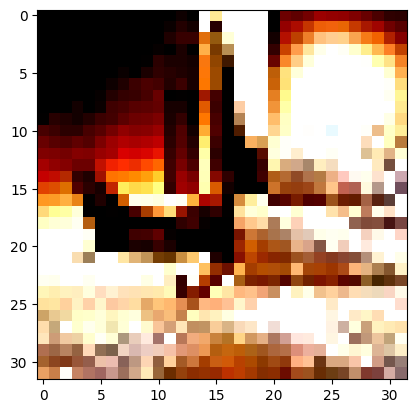

In [ ]:
plt.imshow(img_t.permute(1, 2, 0), cmap='gray')

In [ ]:
with torch.no_grad():
    img_t = img_t.to(device='cuda')
    output = model(img_t)
    _, pred = torch.max(output, dim=1)
print(pred)

tensor([1], device='cuda:0')


In [ ]:
img2 = cv2.imread('/content/1613217694_121-p-fon-sinyaya-pti.jpg')
img2_t = transformer(img2)

In [ ]:
with torch.no_grad():
    img2_t = img2_t.to(device='cuda')
    output = model(img2_t)
    _, pred = torch.max(output, dim=1)
print(pred)

tensor([1], device='cuda:0')
